# Задача 1. 

## Описание проекта  и цель

Построить математическую модель стоимости жилья в зависимости от параметров этого жилья.

## Описание данных 

В качестве источника исходных данных предлагается использовать данные сайта магнитогорской недвижимости www.citystar.ru. Данные о недвижимости собраны и загружены в базу данных.  

Столбцы:
 - url - ссылка на объявление 
 - date_app, date_update
 - note
 - apartment_type
 - neighborhood
 - street
 - house
 - floor
 - layout
 - total_area, living_area, kitchen_area
 - views
 - price

## План работы

1. Подготовка данных:
 - Открыть файлы и изучить их. 
 - Посмотреть какие данные можно использовать для обучения модели, произвести предобработку данных (пропуски, аномалии).
 - Добавить новые признаки, которые помогут в обучении модели (Feature Engineering).
2. Объединить датасеты в один. Произвести EDA анализ полученных данных.
 - Объединение датафреймов
 - Разбиение датафрейма на выборки и анализ данных
 - Проверка мультиколлинеарности признаков и корреляции с таргетом.
 - Отбор признаков (Feature Selection)
 - Выбор моделей для обучения (2-3 модели).
3. Подбор и обучение моделей:
 - Проверка метрики на тесте константной модели.
 - Подбор лучших гиперапараметров моделей на кросс-валидации.
 - Проверка лучшей модели на тестовой выборке.
 - Определить какие признаки модель посчитала самыми важными для прогноза.
4. Выводы - отчет.

## 1. Подготовка данных

In [56]:
# Импорт библиотек
import warnings
import re

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import sqlite3

warnings.filterwarnings('ignore')

In [57]:
#Константы
RANDOM_STATE = 42
TEST_SIZE = 0.2

### Откроем файл и изучим его

In [58]:
conn = sqlite3.connect('base.db')

In [59]:
df = pd.io.sql.read_sql('SELECT * FROM News', conn)
df.head()

,url,date_app,date_update,note,apartment_type,neighborhood,street,house,floor,layout,total_area,living_area,kitchen_area,price,views
0,http://citystar.ru/scard.asp?d=43&id=15909839,30.08.2023 21:52:02,30.08.2023 21:52:02,"Светлая, просторная, уютная квартира в отлично...",Трехкомнатная,Ленинский,Карла Маркса,55,2/5,ленинградский проект,76.0,50.0,9.0,6000,4
1,http://citystar.ru/scard.asp?d=43&id=15909838,30.08.2023 21:47:17,30.08.2023 21:47:45,"Трёхкомнатная раздельная, с просторной кухней,...",Трехкомнатная,Орджоникидзевский,50-летия Магнитки,61,3/9,нестандартная,61.0,45.0,9.0,5100,5
2,http://citystar.ru/scard.asp?d=43&id=15909830,30.08.2023 14:57:57,30.08.2023 14:58:35,Продается 4-х комнатная квартира нестандартной...,Четырехкомнатная,Орджоникидзевский,Труда,18,9/9,,79.0,52.7,8.2,6350,19
3,http://citystar.ru/scard.asp?d=43&id=15909832,30.08.2023 17:06:13,30.08.2023 17:06:13,СРОЧНО!!! - двухкомнатная сталинка по цене одн...,Двухкомнатная,Ленинский,Строителей,52,2/3,старой планировки,54.1,37.1,6.8,3199,11
4,http://citystar.ru/scard.asp?d=43&id=15909831,30.08.2023 15:22:27,30.08.2023 15:22:27,В продаже 4-х комнатная квартира. С хорошим ре...,Трехкомнатная,Орджоникидзевский,Труда,14,8/9,,80.0,53.0,9.0,5999,10


In [60]:
# Посмотрим на размеры файла
df.shape

(400, 15)

In [61]:
# Проверка на пропуски
df.isna().sum()

url               0
date_app          0
date_update       0
note              0
apartment_type    0
neighborhood      0
street            0
house             0
floor             0
layout            0
total_area        0
living_area       0
kitchen_area      0
price             0
views             0
dtype: int64

In [62]:
df.iloc[2]['layout']

''

Пропусков нет, но есть значения с пустыми строками.

In [63]:
# Проверка на дубликаты
df.drop(['url', 'date_app', 'date_update', 'views'], axis = 1).duplicated().sum()

3

In [64]:
# Посмотрим на дубликаты
df.loc[df.drop(['url', 'date_app', 'date_update', 'views'], axis = 1).duplicated()]

,url,date_app,date_update,note,apartment_type,neighborhood,street,house,floor,layout,total_area,living_area,kitchen_area,price,views
343,http://citystar.ru/scard.asp?d=43&id=15173851,05.05.2023 10:39:56,05.05.2023 10:39:56,,Двухкомнатная,Правобережный,"Им. газеты ""Правда""",23,4/5,,46.1,29.0,6.0,2600,68
349,http://citystar.ru/scard.asp?d=43&id=15157805,03.05.2023 7:56:17,03.05.2023 7:56:17,id:4253. \r\nВНИМАНИЕ! ЭКСКЛЮЗИВНОЕ ПРЕДЛОЖЕНИ...,Двухкомнатная,правобережный,ул Помяловского,7,4/5,,43.5,27.0,6.0,2650,50
350,http://citystar.ru/scard.asp?d=43&id=15157804,03.05.2023 7:56:17,03.05.2023 7:56:17,id:4252. \r\nВНИМАНИЕ! ЭКСКЛЮЗИВНОЕ ПРЕДЛОЖЕНИ...,Трехкомнатная,Орджоникидзевский,ул Репина,12,1/1,,55.0,39.0,6.0,0,41


In [65]:
# Удалим дубликаты
df = df.drop_duplicates(subset = df.columns[3:-1].to_list())
df.shape

(397, 15)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397 entries, 0 to 399
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   url             397 non-null    object 
 1   date_app        397 non-null    object 
 2   date_update     397 non-null    object 
 3   note            397 non-null    object 
 4   apartment_type  397 non-null    object 
 5   neighborhood    397 non-null    object 
 6   street          397 non-null    object 
 7   house           397 non-null    object 
 8   floor           397 non-null    object 
 9   layout          397 non-null    object 
 10  total_area      397 non-null    float64
 11  living_area     397 non-null    float64
 12  kitchen_area    397 non-null    float64
 13  price           397 non-null    int64  
 14  views           397 non-null    int64  
dtypes: float64(3), int64(2), object(10)
memory usage: 49.6+ KB


Видно, что у столбца floor тип данных указан object. Изменим на int64. 

#### floor

In [67]:
df['total_floors'] = df['floor'].apply(lambda x: x.split('/')[1])
df['floor'] = df['floor'].apply(lambda x: x.split('/')[0])

In [68]:
df['total_floors'] = df['total_floors'].astype('int64')
df['floor'] = df['floor'].astype('int64')

#### date_app, date_update

In [69]:
# В столбцах с date_app и date_update оставим только дату, без времени и переведем в соответствующий формат
df['date_app'] = pd.to_datetime(df['date_app'].apply(lambda x: x.split()[0]))
df['date_update'] = pd.to_datetime(df['date_update'].apply(lambda x: x.split()[0]))

In [70]:
# Посмотрим на минимальное и максимальное значения столбца
df['date_app'].min(), df['date_app'].max()

(Timestamp('2021-10-25 00:00:00'), Timestamp('2023-08-30 00:00:00'))

In [71]:
# Посмотрим на минимальное и максимальное значения столбца
df['date_update'].min(), df['date_update'].max()

(Timestamp('2023-03-16 00:00:00'), Timestamp('2023-08-30 00:00:00'))

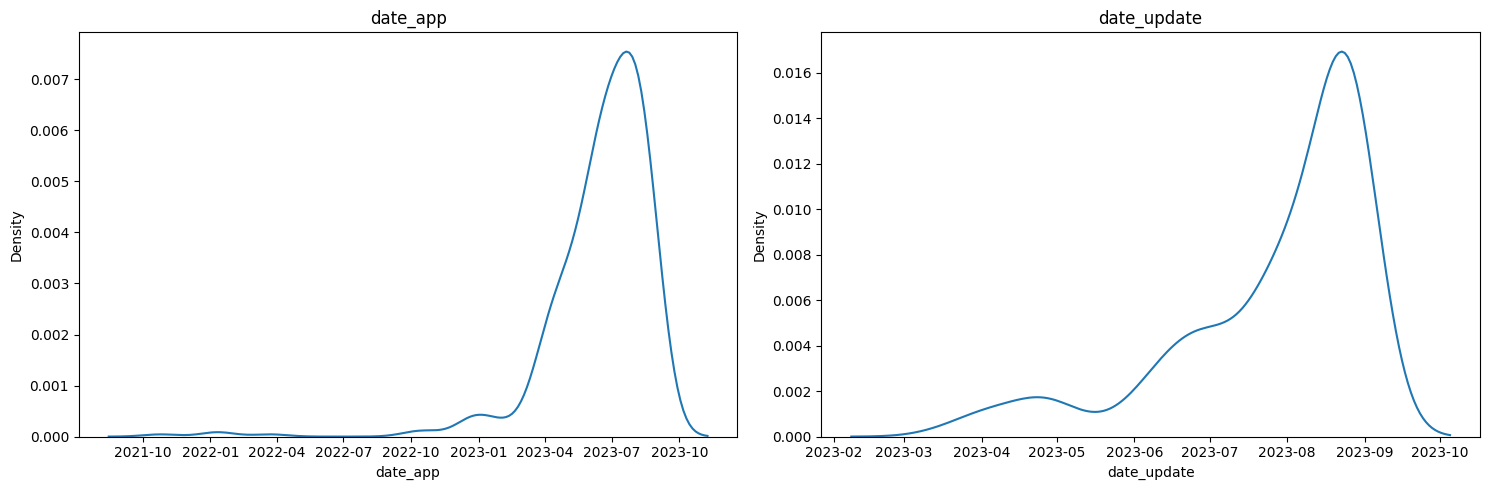

In [72]:
# 
features = ['date_app', 'date_update']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i in range(2):
    sns.kdeplot(data=df, x = features[i], ax=axes[i])
    axes[i].set_title(f'{features[i]}')
plt.tight_layout()
plt.show()

Видно, что представлены объявления о продаже недвижимости за период с октября 2021 года по август 2023. Период обновления (редактирования) представлен с марта 2023 по август 2023г.

Ожидаемо, основная масса объявлений были опубликованы в 2023 году, в период с апреля по август и редактировалась большая часть из них в последний месяц. Т.е. нерелевантных объявлений нет.

#### note

In [73]:
cat_columns = ['url', 'note', 'apartment_type', 'neighborhood', 'street', 'layout']
cat_columns

['url', 'note', 'apartment_type', 'neighborhood', 'street', 'layout']

In [74]:
# Приведем все строковые значения к нижнему регистру
df[cat_columns] = df[cat_columns].apply(lambda row: row.str.lower(), axis = 1)
df.head()

,url,date_app,date_update,note,apartment_type,neighborhood,street,house,floor,layout,total_area,living_area,kitchen_area,price,views,total_floors
0,http://citystar.ru/scard.asp?d=43&id=15909839,2023-08-30,2023-08-30,"светлая, просторная, уютная квартира в отлично...",трехкомнатная,ленинский,карла маркса,55,2,ленинградский проект,76.0,50.0,9.0,6000,4,5
1,http://citystar.ru/scard.asp?d=43&id=15909838,2023-08-30,2023-08-30,"трёхкомнатная раздельная, с просторной кухней,...",трехкомнатная,орджоникидзевский,50-летия магнитки,61,3,нестандартная,61.0,45.0,9.0,5100,5,9
2,http://citystar.ru/scard.asp?d=43&id=15909830,2023-08-30,2023-08-30,продается 4-х комнатная квартира нестандартной...,четырехкомнатная,орджоникидзевский,труда,18,9,,79.0,52.7,8.2,6350,19,9
3,http://citystar.ru/scard.asp?d=43&id=15909832,2023-08-30,2023-08-30,срочно!!! - двухкомнатная сталинка по цене одн...,двухкомнатная,ленинский,строителей,52,2,старой планировки,54.1,37.1,6.8,3199,11,3
4,http://citystar.ru/scard.asp?d=43&id=15909831,2023-08-30,2023-08-30,в продаже 4-х комнатная квартира. с хорошим ре...,трехкомнатная,орджоникидзевский,труда,14,8,,80.0,53.0,9.0,5999,10,9


В данном столбце представлено описание продаваемой недвижимости.

In [75]:
df['note'].iloc[np.random.randint(len(df))]

'полусмежная в хорошем состоянии брежневка с холлом. одна комната отдельная, две другие полусмежные. торцевая очень теплая квартира - радиаторы внешние чугунные, толщина внешних стен пол метра! отличная звукоизоляция! на кухне частично кафель, зимний холодильник, антресоль, кладовка. входная надежная железная дверь, балкон застеклен. в отдельной комнате удобная глубокая кладовка. все стены, потолки, полы ровные, полы нигде не скрипят, эл проводка медная внутренняя. сан узел раздельный, все счетчики новые, эл счетчик матричный.\r\nостается мебель по взаимной договоренности.\r\nотличный район! рядом школы, дет сады, отличная транспортная развязка, все магазины в шаговой доступности. дом в квартале, шум транспорта не беспокоит, обустроены парковочные места.'

Что будем делать с этим безобразием?

#### apartment_type

In [76]:
df['apartment_type'].unique()

array(['трехкомнатная', 'четырехкомнатная', 'двухкомнатная',
       'однокомнатная', 'многокомнатная', ''], dtype=object)

In [77]:
df['apartment_type'].value_counts()

apartment_type
двухкомнатная       137
трехкомнатная       135
однокомнатная        99
четырехкомнатная     15
многокомнатная        6
                      5
Name: count, dtype: int64

Данных нет только в пяти случаях.

#### neighborhood, street

In [78]:
df['neighborhood'].unique()

array(['ленинский', 'орджоникидзевский', '', 'правобережный',
       'орджоникидзевский (левый берег)', 'правобережный район',
       'ленинский (левый берег)'], dtype=object)

In [79]:
df.loc[df['neighborhood'] == 'правобережный район', 'street'].unique()

array(['ул имени газеты правда'], dtype=object)

In [80]:
df.loc[df['neighborhood'] == 'правобережный', 'street'].unique()

array(['карла маркса', 'завенягина', 'грязнова', 'ленина пр-т',
       'им. газеты "правда"', 'сталеваров', 'ул. суворова 95 к.1',
       'советская', 'суворова', 'советской армии',
       'ул. феодосия воронова', 'галиуллина', 'ул грязнова', 'мичурина',
       'советский переулок', 'ул. имени газеты правда',
       'советский переулок 12', 'ул помяловского', 'гагарина',
       'индустриальная'], dtype=object)

Видны опечатки в названии районов, например, правобережный и правобережный район - это один и тот же район.

In [81]:
# Избавимся от опечаток
df.loc[df['neighborhood'] == 'правобережный район', 'neighborhood'] = 'правобережный'

In [82]:
# Посмотрим как часто не указан район
len(df.loc[df['neighborhood'] == ''])

152

Район не указан почти в 40% случаев. Оценим ситуацию с улицами. Для этого названия улиц приведем к единому формату.

In [83]:
# Убираем цифры и лишние символы в названиях улиц
df['street'] = df['street'].apply(lambda x: x.replace('ул ', ''))
df['street'] = df['street'].apply(lambda x: x.replace('ул. ', ''))
df['street'] = df['street'].apply(lambda x: x.replace(' пр-т', ''))
df['street'] = df['street'].apply(lambda x: re.sub(r'[^а-яё\s]', '', x).strip())

In [84]:
df.groupby('street')['neighborhood'].agg('count').sort_values(ascending = False)[:10]

street
ленина            60
карла маркса      53
советская         19
зеленый лог       19
труда             16
летия магнитки    13
грязнова           9
московская         8
курортная          8
                   7
Name: neighborhood, dtype: int64

Чаще всего продаются квартиры на ул. Ленина, Маркса, Советсткой, Зеленый лог, труда. Возможно, это связано с тем, что проспект Ленина и проспект Карла Маркса - одни из самых протяженных в Магнитогорске.

In [85]:
# Определим наблюдения у которых не заполнено поле street
len(df.loc[df['street'] == ''])

7

In [86]:
df['street'].unique()

array(['карла маркса', 'летия магнитки', 'труда', 'строителей',
       'советская', 'первомайская', 'панькова', 'российская', 'ленина',
       'разина', 'мичурина', 'завенягина', 'куйбышева', 'ворошилова',
       'коробова', 'жукова', 'октябрьская', 'галиуллина', 'центральная',
       'горького', 'лесная', 'чайковского', 'грязнова', 'новая',
       'писарева', 'зеленый лог', 'московская', 'им газеты правда',
       'салтыковащедрина', 'сталеваров', 'суворова  к', 'бориса ручьева',
       'западное шоссе', 'уральская', 'тарасенко', 'менделеева',
       'тевосяна', 'имени газеты правда', 'трамвайная', 'пекинская',
       'металлургов', 'лесопарковая', 'герцена', 'чапаева', 'суворова',
       'сиреневый проезд', 'советской армии', 'школьная', 'болотная',
       'бурденко', 'набережная', 'феодосия воронова', 'вокзальная',
       'чекалина', 'доменщиков', 'лермонтова', 'фадеева', '', 'курортная',
       'черемушки', 'молодежный', 'корсикова', 'комсомольская',
       'горнолыжная', 'николая 

#### layout

In [87]:
df['layout'].unique()

array(['ленинградский проект', 'нестандартная', '', 'старой планировки',
       'брежневка', 'хрущевка', 'улучшенная', 'малосемейка',
       'полусмежная', 'раздельная', 'свердловский вариант', 'полустудия',
       'индивидуальный проект', 'гребенка', 'сталинский вариант',
       'распашонка', 'студия'], dtype=object)

In [88]:
df['layout'].value_counts()[:10]

layout
                        286
брежневка                21
улучшенная               19
нестандартная            18
старой планировки        16
раздельная               11
хрущевка                  5
сталинский вариант        4
ленинградский проект      3
гребенка                  3
Name: count, dtype: int64

Данный признак скорее всего не будет информативным так как почти 3/4 значений не заполнено. Остальные значения встречаются крайне редко.

In [89]:
df = df.drop('layout', axis = 1)

In [90]:
df.drop(['date_app', 'date_update'], axis = 1).describe()

,floor,total_area,living_area,kitchen_area,price,views,total_floors
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,3.675063,56.918212,32.555264,8.613778,3557.458438,54.649874,6.319899
std,2.635750,28.935486,17.891120,3.966348,1618.014777,68.510235,3.671613
min,1.000000,14.100000,0.000000,0.000000,0.000000,2.000000,1.000000
25%,2.000000,42.000000,19.000000,6.000000,2550.000000,23.000000,4.000000
50%,3.000000,52.800000,31.000000,8.000000,3360.000000,39.000000,5.000000
75%,5.000000,65.300000,44.000000,10.000000,4400.000000,65.000000,9.000000
max,14.000000,318.000000,150.000000,35.500000,12750.000000,1015.000000,17.000000


В данным видны аномалии - у которых стоимость равна 0, такие наблюденя лучше исключить из датасета. 

In [35]:
df = df.loc[df['price'] != 0]

In [38]:
len(df.loc[df['living_area'] == 0])

34

In [39]:
len(df.loc[df['kitchen_area'] == 0])

11

In [42]:
df.loc[df['kitchen_area'] == 0, 'note']

111    старт продаж !!!br    новая квартира студия на...
182    предлагаем вашему вниманию квартиру в новом жи...
199    представляем вашему вниманию уютную студию с р...
206    продам однокомнатную квартиру - студию в идеал...
212    id:4041. \r\nпродам однокомнатную квартиру с о...
250    id:4836. \r\nв продаже уютная трёхкомнатная кв...
257    id:1182. \r\nпродается теплая полусмежная трех...
295    id:4834. \r\nв продаже шикарная трёхкомнатная ...
346    продам апартаменты на озере банное, в центре д...
391    id:2882. \r\n3-х квартира 9/9 этаж, рядом школ...
395    квартиры на банном в жк панорама. отличное мес...
Name: note, dtype: object

Так же видно, что в 11 случаях не указана площадь кухни, а в 34 случаях не указана жилая площадь. Такие данные тоже лучше исключать из датасета, так как это ошибка или пропуск по сути. Но так как данных мало оставим эти строки.

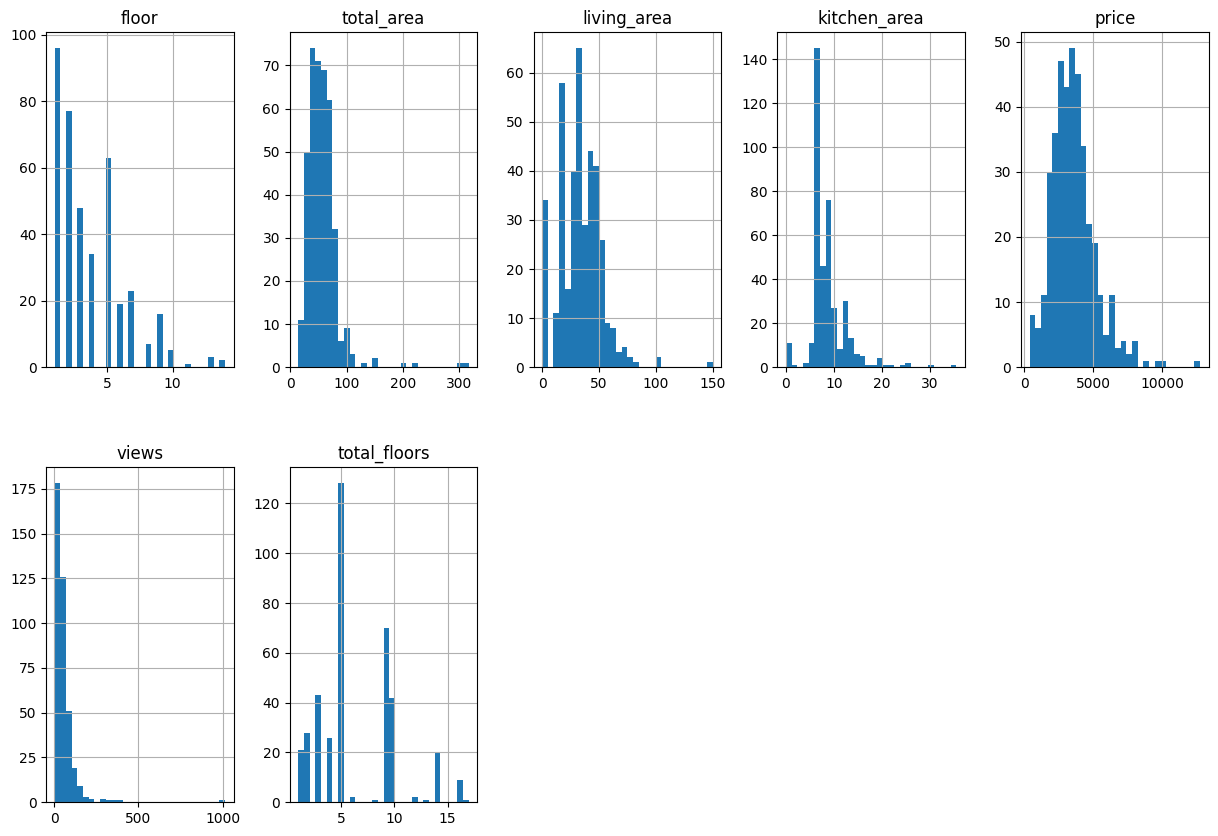

In [49]:
# Добавили ; в конце, чтобы не выводилась служебная информация
df.drop(['date_app', 'date_update'], axis = 1).hist(figsize=(15, 10), layout=(-1, 5), bins = 30);

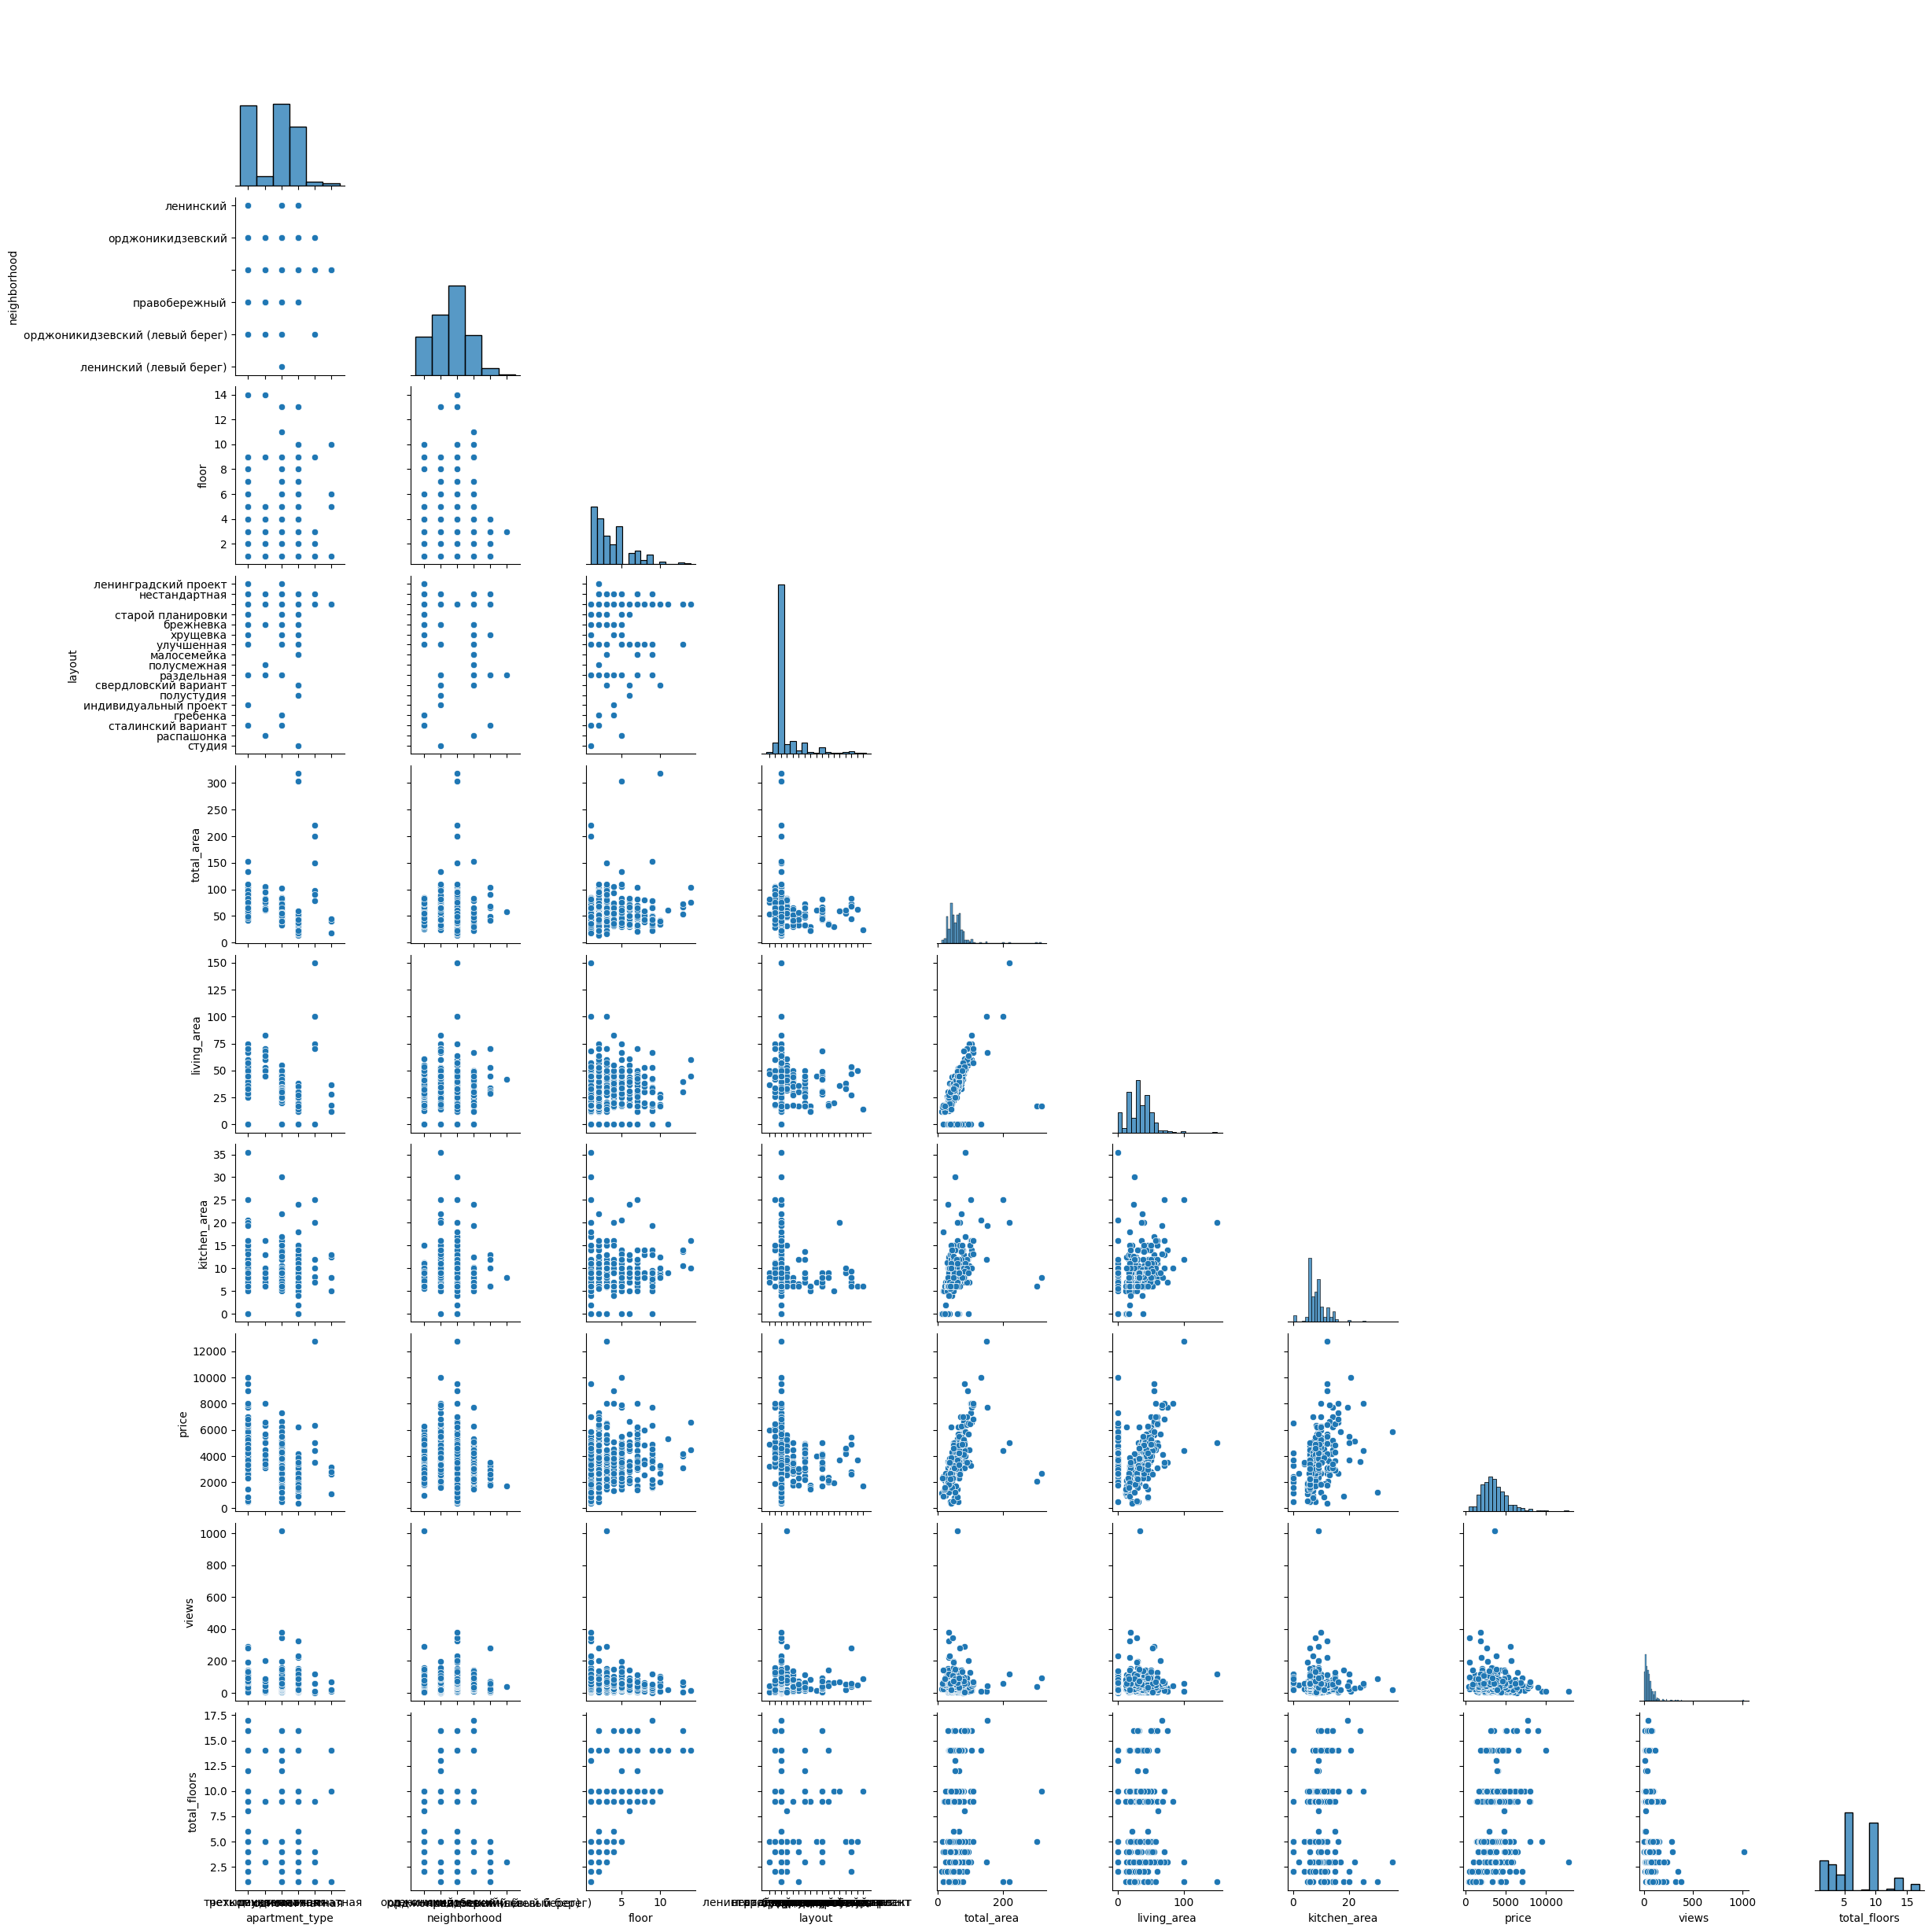

In [53]:
sns.pairplot(
    df,
    vars=['apartment_type',
       'neighborhood', 'floor', 'layout', 'total_area',
       'living_area', 'kitchen_area', 'price', 'views', 'total_floors'],
    corner=True,
);

Как и ожидалось, видна положительная взаимосвязь между признаками с площадью и стоимостью.

In [50]:
df.columns

Index(['url', 'date_app', 'date_update', 'note', 'apartment_type',
       'neighborhood', 'street', 'house', 'floor', 'layout', 'total_area',
       'living_area', 'kitchen_area', 'price', 'views', 'total_floors'],
      dtype='object')

In [ ]:
conn.close()